In [2]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 14.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=705a8bd5a14da79dcf0e95525df5ea045c337799bccaf7bbae3682ce3e49cb71
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=986a07647fbe878b5b9114b6d683a14865f5d710748a7f776bf0b1e54cb92528
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully bu

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
IMG_SIZE = 256

In [5]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    """ Изменяет размер изображения и его цветовую схему
    """

    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))

    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)

    return resized_image, resized_mask

In [6]:
class LipsDataset(torch.utils.data.Dataset):

    def __init__(self, data, preprocessing=None):
        """ Сохраняем путик к изображениям и масквам, а так же количество записей
        """
        self.data = data
        self.preprocessing = preprocessing

        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]

        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        # получем ищображение и маску по их индексу
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]

        # преобразуем изображение и макску к одному виду
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)

        img = img.astype(float)

        # выполняем предюобработку если она задана
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0

        # выполняем перестановку столбцов
        img = img.permute(2, 0, 1)

        # все маски с нужным цветом преобразуем в тензор с 1 и 0
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')
        masks = [cls_mask_1]
        masks = torch.as_tensor(masks, dtype=torch.float)


        return img.float(), masks

In [7]:
# получаем изображения маски и пути к ним
DATASET_FILEPATH = Path('./drive/MyDrive/Colab Notebooks/')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [8]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [9]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [ ]:
# получаем множества путей к изображениям и маскам
list_of_an_images = sorted(set([i for i in Path(IMAGES_FILEPATH).iterdir()]))
list_of_a_masks = sorted(set([i for i in Path(MASKS_FILEPATH).iterdir()]))

In [10]:
# видим что для некоторых изображений отсутствуют пути
len(list_of_an_images), len(list_of_a_masks)

(28663, 28758)

In [11]:
# оставляем только изображения для которых есть маска
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [12]:
# инициализируем модель сегментации
BACKBONE = 'resnet34'

segmodel = smp.Linknet(encoder_name=BACKBONE, classes=1, activation='sigmoid').to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [13]:
# получаем даныйе для обучения и теста
X_train, X_valid = train_test_split(df_lips_images, test_size=0.2, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [14]:
a = X_train.iloc[:, 1]
a

0        mask00028042.png
1        mask00002827.png
2        mask00016865.png
3        mask00021794.png
4        mask00005674.png
               ...       
22827    mask00021630.png
22828    mask00005391.png
22829    mask00000861.png
22830    mask00015850.png
22831    mask00023709.png
Name: mask, Length: 22832, dtype: object

In [15]:
X_train.shape, X_valid.shape

((22832, 2), (5708, 2))

In [16]:
# загружаем данные
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=False)

<ipython-input-5-2e0e0729d8b9>:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  masks = torch.as_tensor(masks, dtype=torch.float)


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)


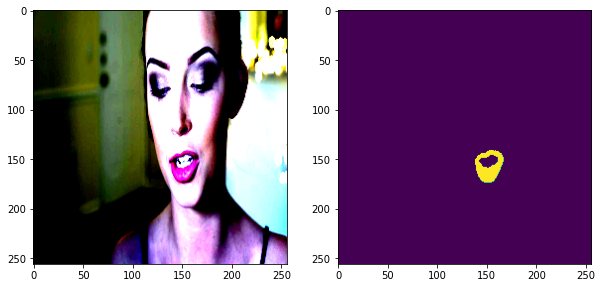

In [17]:
# проверяем что все работает
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    im = np.squeeze(masks[0].permute(1, 2, 0))
    ax[1].imshow(im)
    break

In [18]:
# выбираем параметры для настройки сети
criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [19]:
# иницализируем обработчики тренировочной и валидационой эпох
train_epoch = smp.utils.train.TrainEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    device=device,
    verbose=True
)

In [20]:
# обучаем сеть

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 714/714 [1:03:32<00:00,  5.34s/it, bce_loss - 0.00203, iou_score - 0.9354]
Model saved!


In [1]:
# смотрим на результат
data_iter = iter(train_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

for i in range(images.shape[0]):

    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))

    image = images[i].permute(1, 2, 0)

    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')

    ax_2.imshow(np.squeeze(labels[i, ].cpu().permute(1, 2, 0)))
    ax_2.set_title('True_mask')

    ax_3.imshow(np.squeeze(outputs.detach().cpu()[i, ].permute(1, 2, 0)))
    ax_3.set_title('Pred_mask')

NameError: ignored